In [1]:
pip install -Uqq fastbook

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install streamlit

Note: you may need to restart the kernel to use updated packages.


In [ ]:
!unzip -q /content/cats.zip -d ../

In [10]:
!unzip -q /content/cats.zip -d /content/

Import relevant libraries

In [7]:

import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.vision.widgets import *
from pathlib import Path

Mounted at /content/gdrive


In [8]:
fns = get_image_files('./cats')

### Dataloader
Before training, we want to let the model know:

the types of data
how to get data
how to get the labels of the dataset
how to split the data into train and validation set
That is when Dataloader comes in handy. Start with creating DataBlock and feed this instance to dataloaders

In [11]:

cats = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=1),
    get_y=parent_label,
    item_tfms=Resize(128))
    
dls = cats.dataloaders('./cats/')

View 4 random images in our dataloaders

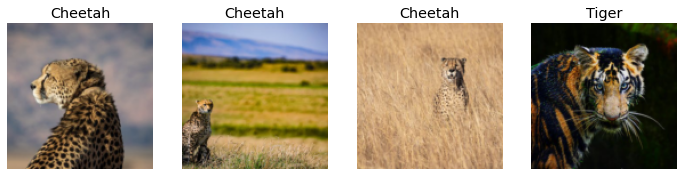

In [12]:
dls.valid.show_batch(max_n=4, nrows=1)

# Random Resize and Data Augmentation
The images above are good as they are. But for the neural network to capture more of our images, we want to improve our method of transforming images. That could be done by using random resize and data augmentation.

# Random Resize
For many types of neural networks, the inputs always need to have the same shape. So we want to crop the images so that they are all the same size.

By default, Resize crops the images to fit a square shape. This might result in a loss of important pieces of images. So instead of cropping the same area, we will use RandomResizedCrop to randomly select and crop one part of the image.

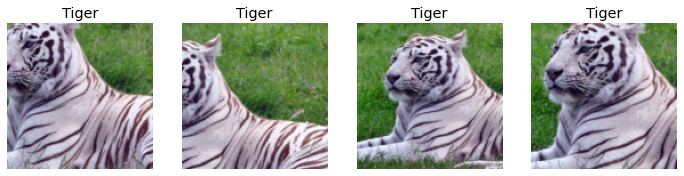

In [13]:
cats = cats.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = cats.dataloaders('./cats')
dls.train.show_batch(max_n=4, nrows=1, unique=True)

# Data Augmentation
To create more training data, we will use batch_tfms to apply augmentations to a whole dataset. This means to rotate, flip, change the brightness of the images, etc to create different images from the same image.

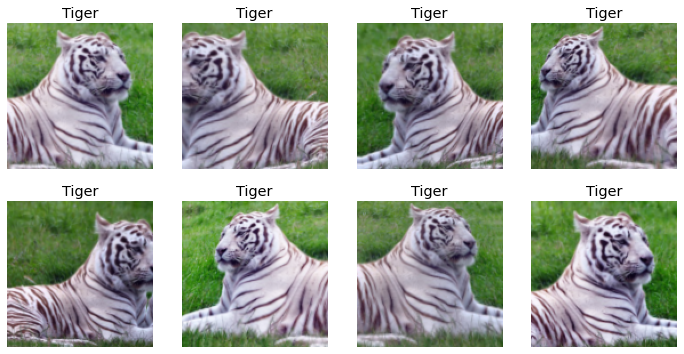

In [14]:
cats = cats.new(item_tfms=Resize(128), batch_tfms=aug_transforms())
dls = cats.dataloaders('./cats/')
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Combine both techniques to get the benefits of both transformations

In [15]:
cats = cats.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = cats.dataloaders('./cats/')

## Train our Model
We use a convolution neural network (CNN) with architecture ResNet to train our model. cnn_learner will also load a pre-trained model that have already been trained to recognize a thousand different categories across 1.3 million photos.

In [16]:
learn = cnn_learner(dls, resnet50, metrics=error_rate)
learn.fine_tune(1)

/usr/local/lib/python3.8/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.509913,0.155319,0.027714,14:15


epoch,train_loss,valid_loss,error_rate,time
0,0.155860,0.142346,0.032333,18:57


## Evaluate our model

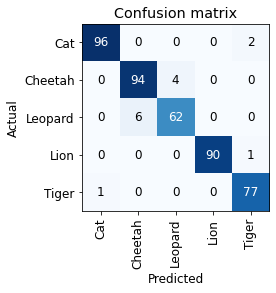

In [17]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

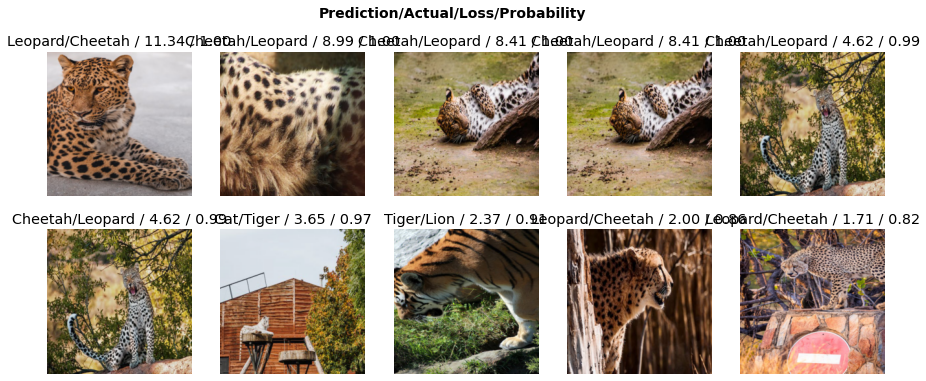

In [18]:
# Images wrongly classified
interp.plot_top_losses(10, nrows=2)

In [19]:
interp.most_confused(min_val=5)

[('Leopard', 'Cheetah', 6)]

## Improving Our Model
Now let's take it one step further. Let's dive into transfer learning and how to fine-tune our pretrained model as best as possible, without breaking the pretrained weights.

The first thing we need to set when training a model is the **learning rate.** We saw in the previous lesson that it needs to be just right to train as efficiently as possible, so how do we pick a good one? fastai provides a tool for this.

**The Learning Rate Finder**

One of the most important things we can do when training a model is to make sure that we have the right learning rate. If our learning rate is too low, it can take many, many epochs to train our model. Not only does this waste time, but it also means that we may have problems with overfitting, because every time we do a complete pass through the data, we give our model a chance to memorize it.

So let's just make our learning rate really high, right? Sure, let's try that and see what happens:

In [ ]:
resnet34_overtrain = vision_learner(dls, resnet34, metrics=error_rate)
resnet34_overtrain.fine_tune(1, base_lr=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.592662,4.419199,0.177829,10:05


epoch,train_loss,valid_loss,error_rate,time


That doesn't look good. Here's what happened: the optimizer stepped in the correct direction, but it stepped so far that it totally overshot the minimum loss. Repeating that multiple times makes it get further and further away, not closer and closer! (BTW if we didn't specify the learning rate manually, the default would have been used, i.e. 1e-3 (0.001))

What do we do to find the perfect learning rate—not too high, and not too low? In 2015 the researcher Leslie Smith came up with a brilliant idea, called the learning rate finder.

The tool will do a 'quick search', using the chosen architecture and data, to try and find the best learning rate (where the loss goes down the most, the steepest part (highest gradient), and hopefully as far right as possible, because a higher learning rate equals faster learning)

SuggestedLRs(valley=0.0004786300996784121)

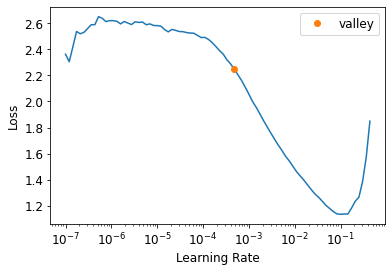

In [21]:
resnet34_just_right = vision_learner(dls, resnet34, metrics=error_rate)
resnet34_just_right.lr_find()

In this situation, the tool will probably suggest something between 0.001 and 0.01. It depends on the quick search. You can check this by running the code block above a couple more times. You'll notice that the suggested LR will change a little bit each time.

You can also see that a learning rate around the 0.1 mark is really dangerous. That's the point our loss tends to shoot up, and make our learning very unstable.

# **Unfreezing & Transfer Learning**

When we create a model from a pretrained network, fastai automatically freezes all of the pretrained layers for us. When we call the fine_tune method fastai does 2 things:

1.   Trains the randomly added layers for one epoch, with all other layers frozen.
2.   Unfreezes all of the layers, and trains them **all** for the number of epochs requested.

Although this is a reasonable default approach, it is likely that for your particular dataset you may get better results by doing things slightly different. 

In [22]:
resnet_adv = vision_learner(dls, resnet34, metrics=error_rate)
resnet_adv.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.740088,0.094224,0.025404,09:13
1,0.356898,0.068567,0.013857,09:09
2,0.216512,0.045467,0.013857,09:22


In [23]:
resnet_adv.unfreeze()

Let's run lr_find again, because having more layers to train, and weights that have already been trained for three epochs, means our previously found learning rate isn't appropriate any more:

SuggestedLRs(valley=2.2908675418875646e-06)

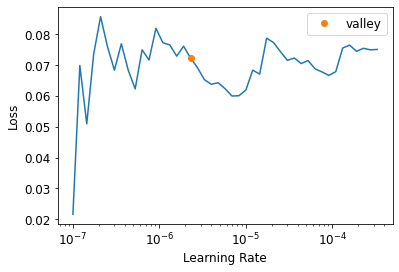

In [24]:
resnet_adv.lr_find()

Note that the graph is a little different from when we had random weights: we don't have that sharp descent that indicates the model is training. That's because our model has been trained already. So finding a good learning rate isn't that straightforward anymore...

In [ ]:
resnet_adv.fit_one_cycle(6, 1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.072065,0.038762,0.013857,13:18
1,0.064319,0.037081,0.013857,13:23
2,0.058586,0.034283,0.013857,13:25


epoch,train_loss,valid_loss,error_rate,time
0,0.072065,0.038762,0.013857,13:18
1,0.064319,0.037081,0.013857,13:23
2,0.058586,0.034283,0.013857,13:25
3,0.050967,0.033169,0.013857,13:14
4,0.053164,0.040807,0.013857,13:19


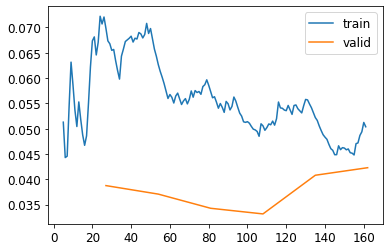

In [26]:
resnet_adv.recorder.plot_loss()

## Save the model
That’s it! Now we can export our model to put into production

In [27]:
resnet_adv.export('cats.pkl')